<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/machine_translation_using_luong_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Description

We're going to build an NN model to translate from Russian to English. This notebook is committed to the implementation of the encoder-decoder network with Luong attention (Multiplicative Attention) mechanism.

We will use the following terms:
- source language - the language from which the model translates
- target language - the language to which the model translates
- token = word


Dataset: https://www.kaggle.com/datasets/hijest/englishrussian-dictionary-for-machine-translate/

References:
- https://arxiv.org/abs/1508.04025
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
- https://www.youtube.com/watch?v=vI2Y3I-JI2Q
- https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
- https://blog.floydhub.com/attention-mechanism/



In [2]:
from typing import List
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from string import punctuation
from collections import Counter
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


# 1. Vectorization

In [3]:
UNKNOWN_TOKEN = '[UNK]' # Out of vocabulary token
START_TOKEN = '[START]' # The token that denotes the beginning of the target language phrase
END_TOKEN = '[END]' # The token that denotes the end of the target language phrase

In [4]:
class Vectorization:
  '''
    Vectorization text class.
    Main goals:
     - make a vocabulary
     - convert the list of strings to the list of integer tokens
     - convert the list of integer tokens to the list of strings
  '''

  def __init__(self,
               max_tokens,
               max_length=None,
               unknown_token=UNKNOWN_TOKEN,
               start_token=START_TOKEN,
               end_token=END_TOKEN
               ):
    '''
      :param max_tokens: length of the vocabulary
      :param max_length: max length of the phrases
      :param unknown_token: out of vocabulary token
      :param start_token: token that denotes the beginning of the phrase
      :param end_token: token that denotes the end of the phrase
    '''
    self.max_tokens = max_tokens
    self.max_length = max_length
    self.unknown_token = unknown_token
    self.start_token = start_token
    self.end_token=end_token
    # add to the vocabulary:
    #  (1) padding token (we're going to pad using 0, so padding token index is 0)
    #  (2) out of vocabulary token
    #  (3) start token
    #  (4) end token
    self.vocabulary = ['', self.unknown_token, self.start_token, self.end_token]

  def __preprocessing(self, input: str) -> str:
    '''
      Preprocess of the string (convert to lowcase and remove punctuation).
      ex.: I'm going! -> i m going
      :param input - input string
      :return preprocessed string
    '''
    output = ''.join(map(lambda ch: ch if ch not in punctuation else ' ', input.lower())).strip()
    return output

  def token_to_text(self, tokens: List) -> str:
    '''
      Convert the list of the integer tokens to the string
      :param tokens: list of the integer tokens
      :return string contains words that correspond to the integer tokens
    '''
    words = [self.vocabulary[token] if token < len(self.vocabulary) else self.unknown_token for token in tokens]
    return " ".join(words)

  def fit(self, X: List, is_add_start_token=False, is_add_end_token=False):
    '''
      Make the vocabulary and calculate the max length of the phrase
      :param X: corpus - list of the strings
      :return the instance of the current class
    '''
    lens = []
    __vocab = []
    for x in X:
      # Make preprocessing and get the list of the words.
      # Ex. I'm going! -> ['i', 'm', 'going']
      words = self.__preprocessing(x).split()

      # Collect phrases lengths
      lens.append(len(words))

      # Make the vocabulary
      __vocab += [word.strip() for word in words]

      # for word in words:
      #   token = word.strip()
      #   # Add the word to the vocabulary if it usn't "full"
      #   if token not in self.vocabulary and self.max_tokens is not None and len(self.vocabulary)<self.max_tokens:
      #     self.vocabulary.append(token)

    c = Counter(__vocab)
    if self.max_tokens:
      self.vocabulary += [item[0] for item in c.most_common(self.max_tokens-4)]
    else:
      self.vocabulary += [item[0] for item in c.most_common()]

    # Calculate the max length of the phrases if it isn't set in the __init__
    # max_length = Average length + two standard devations
    lens = np.array(lens)
    if self.max_length is None:
      self.max_length = int(np.mean(lens) + 2 * np.std(lens)) + int(is_add_start_token) + int(is_add_end_token)
    return self

  def predict(self,
              X: List[str],
              is_padding=True,
              is_add_start_token=False,
              is_add_end_token=False
              ) -> List[List]:
    '''
      :param X - corpus - list of the strings
      :param is_padding - whether to pad the list of tokens to the max. length with 0s
      :param is_add_start_token - whether to add the start_token to the list of tokens
      :param is_add_end_token - whether to add the end_token to the list of tokens
      :return list of the lists of tokens
    '''
    output = []
    # max_length = self.max_length + int(is_add_start_token) + int(is_add_end_token)

    for x in X:
      # If nedded add the index of the start_token to the beginning of the list of tokens
      vector = [self.vocabulary.index(self.start_token)] if is_add_start_token else []

      # Make preprocessing and get the list of the words.
      words = self.__preprocessing(x).split()

      # If the current word is in the vocabulary add its index to the list else add the index of the unknown_token
      for word in words:
        token = word.strip()
        vector.append(self.vocabulary.index(token) if token in self.vocabulary else self.vocabulary.index(self.unknown_token))

      # Truncate the vector to the max. length
      vector = vector[:self.max_length-1]

      # If needed add the index of the end_token
      if is_add_end_token:
        vector.append(self.vocabulary.index(self.end_token))

      output.append(vector)

    # If needed pad the vector to the max. length with 0s
    return pad_sequences(output,
                         maxlen=self.max_length,
                         padding='post',
                         truncating='post') if is_padding else output

In [21]:
# Read from N to M samples
N = 0
M = 100_000

input_phrases, output_phrases = [], []
with open('/content/drive/MyDrive/Colab Notebooks/Data/rus.txt') as f:
  for line in f.readlines()[N:M]:
    eng, rus = line.split('CC-BY')[0].strip().split('\t')
    input_phrases.append(rus)
    output_phrases.append(eng)

In [22]:
input_vocab = 10_000 # size of the source language vocaulary
output_vocab = 10_000 # size of the target language vocaulary

In [23]:
# Make vectorization of the source language phrases
encoder_vec = Vectorization(max_tokens=input_vocab)
encoder_vec.fit(input_phrases)
X_encoder = encoder_vec.predict(input_phrases, is_padding=False)

# Make vectorization of the target language phrases
decoder_vec = Vectorization(max_tokens=output_vocab)
decoder_vec.fit(output_phrases, is_add_start_token=True, is_add_end_token=True)
# For the reason of the sequence model training we need decoder input contains the start_token and
# the decoder output which is without the start_token
X_decoder = decoder_vec.predict(output_phrases, is_add_start_token=True, is_add_end_token=True)
Y_decoder = decoder_vec.predict(output_phrases, is_add_end_token=True)

In [24]:
idx = 100
print(f"Index: {idx}")
print("======= Encoder =======")
print(f"Input phrase: {input_phrases[idx]}")
print(f"Vector: {X_encoder[idx]}")
print(f"Max. length: {encoder_vec.max_length}")
print("======= Decoder =======")
print(f"Input phrase: {output_phrases[idx]}")
print(f"Vector: {X_decoder[idx]}")
print(f"Output phrase: {output_phrases[idx]}")
print(f"Vector: {Y_decoder[idx]}")
print(f"Max. length: {decoder_vec.max_length}")
print("==============")
print(f"Start phrase token index: {decoder_vec.vocabulary.index(START_TOKEN)}")
print(f"End phrase token index: {decoder_vec.vocabulary.index(END_TOKEN)}")

Index: 100
======= Encoder =======
Input phrase: Он бежал.
Vector: [17, 1801]
Max. length: 5
======= Decoder =======
Input phrase: He ran.
Vector: [  2  24 324   3   0   0   0]
Output phrase: He ran.
Vector: [ 24 324   3   0   0   0   0]
Max. length: 7
Start phrase token index: 2
End phrase token index: 3


# 2. Construct Encoder-Decoder model with Bahdanau attention

## 2.1. Encoder model

In [9]:
class Encoder(tf.keras.Model):
  '''
    Encoder for using with Luong attention
  '''
  def __init__(self, input_vocab: int, embedding_dim: int, lstm_hidden_units: int):
    '''
      :param input_vocab - vocabluary dimension of the source language
      :param embedding_dim - dimension of the source language words embeddings
      :param lstm_hidden_units - the number of the LSTM cell units
    '''
    super(Encoder, self).__init__()
    self.emedding = Embedding(input_dim=input_vocab,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name='encoder_embedding')
    self.lstm = LSTM(units=lstm_hidden_units,
                     return_state=True,
                     name='encoder_lstm')

  def __call__(self, x, is_verbose=False):
    '''
      Calculate forward propagation through the Encoder
      :param x - input sequence (batch_size, sequence_length)
    '''
    # Get embeddings.
    # 'x' dimension is (batch_size, sequence_length)
    # 'out' dimension is (batch_size, sequence_length, embedding_dim)
    out = self.emedding(x)

    # Hence we don't need LSTM output, we get only LSTM states (hidden state and cell state)
    # One of the problems here is that dispite the return_sequences parameter is True,
    # we get only last (after propagation a whole sequence) values of the states and
    # didn't get the states after each timestep. We will struggle with this later.
    output, h, c = self.lstm(out)

    if is_verbose:
      print(f"Input shape {x.shape}. Shape after embedding: {out.shape}.")
      print(f"Output LSTM shape: {output.shape}. Hidden state: {h.shape}. Cell state: {c.shape}")

    return h, c

In [10]:
# Test Encoder
enc = Encoder(input_vocab=100, embedding_dim=64, lstm_hidden_units=16)
input = np.zeros((4, 3))
h, c = enc(input, is_verbose=True)

assert input.shape == (4, 3), "Wrong input shape"
assert h.shape == (4, 16), "Wrong hidden state shape"
assert c.shape == (4, 16), "Wrong cell state shape"

Input shape (4, 3). Shape after embedding: (4, 3, 64).
Output LSTM shape: (4, 16). Hidden state: (4, 16). Cell state: (4, 16)


## 2.2. Luong Attention Layer

In [13]:
class LuongAttention(tf.keras.layers.Layer):
  '''
    Layers implements a Bahdanau attention mechanism
  '''
  def __init__(self, units: int, alignment_scoring_function='dot', name=None):
    '''
      :param units - the number of the encoder and decoder hidden units.
      This value can be obtained from the inputs dimensions but for the purpose of simplicity we will set it here.
      :param alignment_scoring_function - the parameter defines how the score between the current decoder hidden
      state and the encoder hidden states will calculate. The possible values are: 'dot', 'general', 'concat'. For
      more information refer to the original paper - https://arxiv.org/abs/1508.04025
      :param name - tne name of the layer
    '''
    super(LuongAttention, self).__init__(name=name)
    self.alignment_scoring_function = alignment_scoring_function

    if self.alignment_scoring_function == 'general':
     self.fc_a = Dense(units=units, activation='linear')
    elif self.alignment_scoring_function == 'concat':
      self.weights = tf.Variable(initial_value=np.random.rand(1, units), name='weights')
      self.fc_a = Dense(units=units, activation='linear')

  def __call__(self, encoder_states, decoder_hidden_state, is_verbose=False):
    '''
      Calculate forward propagation through the Layer
      :param encoder_states - encoder hidden states (batch_size, sequence_length, encoder_lstm_hidden_units)
      :param decoder_hidden_state - decoder hidden state (batch_size, decoder_lstm_hidden_units)
    '''

    if self.alignment_scoring_function == 'dot':
      # if the alignment scoring function is 'dot',
      # we just multiply the current decoder hidden state by the encoder hidden states.
      # dimensions of the 'scores' is (batch_size, source_sequence_length, 1)
      scores = tf.reduce_sum(encoder_states * tf.expand_dims(decoder_hidden_state, 1), -1, keepdims=True)
    elif self.alignment_scoring_function == 'general':
      # if the alignment scoring function is 'general',
      # we first pass the encoder hidden states through the full-connected layer
      # with the linear activation function and then multiply the result by
      # the current decoder hidden states.
      # Dimensions of the 'scores' is (batch_size, source_sequence_length, 1)
      scores = self.fc_a(encoder_states)
      scores = tf.reduce_sum(scores * tf.expand_dims(decoder_hidden_state, 1), -1, keepdims=True)
    elif self.alignment_scoring_function == 'concat':
      pass

    # Calculate attention weights of the each encoder hidden state within a batch
    # attention_weights dimension is (batch_size, sequence_length, 1)
    attention_weights = tf.nn.softmax(scores, axis=1)

    # Calculate context vector. Its dimension is (batch_size, encoder_lstm_hidden_units)
    context_vector = tf.reduce_sum(attention_weights * encoder_states, axis=1)

    if is_verbose:
      print(f"Input: encoder_states shape: {encoder_states.shape}, decoder_hidden_state shape: {decoder_hidden_state.shape}")
      print(f"alignment scoring function: {self.alignment_scoring_function}")
      print(f"alignment_scores shape: {scores.shape}, attention_weights shape: {attention_weights.shape}")
      print(f"context_vector shape: {context_vector.shape}")

    return context_vector, attention_weights

In [14]:
# Test LuongAttention Layer
la = LuongAttention(units=16, alignment_scoring_function='general')
encoder_states = np.zeros((4, 3, 16), dtype=np.float32)
decoder_hidden_state = np.zeros((4, 16), dtype=np.float32)
context_vector, softmax_alignment_scores = la(encoder_states, decoder_hidden_state, is_verbose=True)

Input: encoder_states shape: (4, 3, 16), decoder_hidden_state shape: (4, 16)
alignment scoring function: general
alignment_scores shape: (4, 3, 1), softmax_alignment_scores shape: (4, 3, 1)
context_vector shape: (4, 16)


## 2.3. Decoder model

In [15]:
class Decoder(tf.keras.Model):
  '''
    Decoder with Luong attention mechanism
  '''
  def __init__(self, output_vocab, embedding_dim, lstm_hidden_units, alignment_scoring_function='dot'):
    '''
      :param output_vocab - vocabluary dimension of the target language
      :param embedding_dim - dimension of the target language words embeddings
      :param lstm_hidden_units - the number of the LSTM cell units
      :param alignment_scoring_function - the parameter defines how the score between the current decoder hidden
      state and the encoder hidden states will calculate. The possible values are: 'dot', 'general', 'concat'. For
      more information refer to the original paper - https://arxiv.org/abs/1508.04025
    '''
    super(Decoder, self).__init__()

    self.emedding = Embedding(input_dim=output_vocab,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name='decoder_embedding')

    self.lstm = LSTM(units=lstm_hidden_units,
                     return_sequences=True,
                     return_state=True,
                     name='decoder_lstm')

    self.attention = LuongAttention(units=lstm_hidden_units,
                                    alignment_scoring_function=alignment_scoring_function,
                                    name='decoder_attention')

    self.fc_concatenate = Dense(units=lstm_hidden_units,
                                activation='linear')

    # The Dense layer with softmax activation function for obtaining the probabilities of the tokens
    self.output_dense = Dense(units=output_vocab,
                              activation='softmax',
                              name='decoder_output')

  def __call__(self, x, decoder_states, encoder_states, is_verbose=False):
    '''
      Calculate forward propagation through the Decoder
      :param x - input sequence (batch_size, sequence_length_of_target_lang)
      :param decoder_states - hidden and cell decoder states from the previous timestep (or last encoder states for the first timestep)
      Dimension ((batch_size, lstm_hidden_units), (batch_size, lstm_hidden_units))
      :param encoder_states - hidden encoder states from the each timesteps  (batch_size, sequence_length, lstm_hidden_units)
    '''

    # Get target language embedding
    x_embd = self.emedding(x)

    # Get LSTM outputs
    out_lstm, h, c = self.lstm(x_embd, initial_state=decoder_states)

    # Calculate contect vector based on Bahdanau attention mechanism
    # context_vector dimension is (batch_size, lstm_hidden_units)
    context_vector, attention_weights = self.attention(encoder_states, h)

    # Concatenate context_vector with the next embedded token
    # The concat_vector dimension is (batch_size, lstm_hidden_units + lstm_hidden_units)
    concat_vector = tf.concat([context_vector, h], axis=-1)

    # Pass the concatenated vector through the full-connected layer and
    # then take the tanh of the result.
    # The h_new dimension is (batch_size, lstm_hidden_units)
    h_new = tf.math.tanh(self.fc_concatenate(concat_vector))

    # Propagate LSTM output through dense layer with softmax activation function
    out = tf.expand_dims(self.output_dense(h_new), 1)

    if is_verbose:
      print(f"Input: encoder_states shape: {encoder_states.shape}, x shape: {x.shape}")
      print(f"After embedding shape: {x_embd.shape}, LSTM h shape: {h.shape}, LSTM output shape: {out_lstm.shape} ")
      print(f"context_vector shape: {context_vector.shape}")
      print(f"concat_vector state: {concat_vector.shape}")
      print(f"h_new state: {h_new.shape}")
      print(f"Output after softmax: {out.shape}")

    return out, h, c, attention_weights

In [16]:
# Test Decoder
dec = Decoder(output_vocab=100, embedding_dim=32, lstm_hidden_units=16, alignment_scoring_function='dot')
x = np.zeros((4, 1))
decoder_states = tf.convert_to_tensor(np.zeros((4, 16)), dtype=tf.float32), tf.convert_to_tensor((np.zeros((4, 16))), dtype=tf.float32)
encoder_states = tf.convert_to_tensor(np.zeros((4, 3, 16)), dtype=tf.float32)
out, h, c, _ = dec(x=x, decoder_states=decoder_states, encoder_states=encoder_states, is_verbose=True)

Input: encoder_states shape: (4, 3, 16), x shape: (4, 1)
After embedding shape: (4, 1, 32), LSTM h shape: (4, 16), LSTM output shape: (4, 1, 16) 
context_vector shape: (4, 16)
concat_vector state: (4, 32)
Output after softmax: (4, 1, 100)


## 2.4. Encoder-Decoder model

In [17]:
class Seq2SeqLuongAttention(tf.keras.Model):
  '''
  Encoder-Decoder network implements the Bahdanau attention mechanism
  '''
  def __init__(self,
               input_vocab,
               output_vocab,
               encoder_embd_dim,
               decoder_embd_dim,
               encoder_lstm_units,
               decoder_lstm_units,
               max_output_length,
               start_token_index,
               end_token_index,
               alignment_scoring_function='dot'):
    '''
      :param input_vocab - vocabluary dimension of the source language
      :param output_vocab - vocabluary dimension of the target language
      :param encoder_embd_dim - dimension of the source language words embeddings
      :param decoder_embd_dim - dimension of the target language words embeddings
      :param encoder_lstm_units - the number of the LSTM cell units
      :param decoder_lstm_units - the number of the LSTM cell units
      :param max_output_length - the maximum length of the output sequence
      :param start_token_index - index of the start token in the output vocabulary
      :param end_token_index - index of the end token in the output vocabulary
      :param alignment_scoring_function - the parameter defines how the score
      between the current decoder hidden state and the encoder hidden states
      will calculate. The possible values are: 'dot', 'general', 'concat'. For
      more information refer to the original paper - https://arxiv.org/abs/1508.04025

    '''
    super(Seq2SeqLuongAttention, self).__init__()
    self.encoder = Encoder(input_vocab=input_vocab,
                           embedding_dim=encoder_embd_dim,
                           lstm_hidden_units=encoder_lstm_units)
    self.decoder = Decoder(output_vocab=output_vocab,
                           embedding_dim=decoder_embd_dim,
                           lstm_hidden_units=decoder_lstm_units,
                           alignment_scoring_function=alignment_scoring_function)
    self.max_output_length = max_output_length
    self.start_token_index = start_token_index
    self.end_token_index = end_token_index
    self.__loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
    self.__metric_object = tf.keras.metrics.SparseCategoricalAccuracy()


  def __loss_function(self, true, pred):
    '''
     :param true - ground truth values. Shape (batch_size)
     :param pred - The predicted values. Shape (batch_size, len_of_output_vocab)
    '''
    loss = self.__loss_object(true, pred)
    mask = tf.expand_dims(tf.math.not_equal(true, 0), 1)
    mask = tf.cast(mask, dtype=loss.dtype)
    non_zero_count = tf.reduce_sum(mask)
    return tf.reduce_sum(loss*mask)/non_zero_count if non_zero_count else 0

  def __metric_function(self, true, pred):
    '''
     :param true - ground truth values. Shape (batch_size)
     :param pred - The predicted values. Shape (batch_size, len_of_output_vocab)
    '''
    mask = tf.math.not_equal(true, 0)
    self.__metric_object.update_state(true[mask], pred[mask])
    return self.__metric_object.result().numpy()

  def __forward(self, X_encoder, X_decoder=None, Y_decoder=None):
    '''
      Forward propagation
      :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
      :param X_decoder - input decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 2)
      (ex. [start_token_index, word1_index, woprd2_index, end_token_index)
      :param Y_decoder - output decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 1)
      (ex. [word1_index, woprd2_index, end_token_index)

      We use X_decoder=None and Y_decoder=None for the purpose of prediction
      We use X_decoder=None and Y_decoder is not None for the purpose of validation during training
    '''
    output = np.array([], dtype=np.int32)
    batch_size = X_encoder.shape[0]
    attention_weights = None
    encoder_states = []
    loss = 0
    accuracy = None

    # Here we deal with the mentioned earlier problem of getting encoder hidden states on each timestep.
    # As we mentoined before LSTM parameter 'return_sequences' doesn't affect on the hidden and cell states, i.e.
    # we can't get LSTM states after every timestep. Therefore we need do it manually. It means the following:
    # 1) we take the first token of the input sequence, propagate it through the encoder and save the LSTM states.
    # 2) we take the two first tokens of the input sequence, propagate them through the encoder and save the last LSTM states.
    # 3) We repeat step 2 adding the next token and save the last LSTM states.

    for t in range(X_encoder.shape[1]):
      h, c = self.encoder(X_encoder[:, :t+1])
      encoder_states.append(h)
    encoder_states = tf.stack(encoder_states, axis=1) # make tensor from the list

    # save the last encoder hidden and cell states, since they are the initial decoder states
    hidden_state = encoder_states[:, -1, :]
    cell_state = c

    if X_decoder is not None and Y_decoder is not None: # if we train network
      # for every timestep (i.e. every token) of the target language sequence
      for t in range(X_decoder.shape[1]):
        # Set the decoder_input to the t-th token of the decoder input sequence.
        # We use here the teacher forcing method for faster and efficient decoder training.
        # The method uses the ground true as the decoder input instead of the prediction
        # from the previous timestep. We need decoder_input to have the dimension (batch_size, 1)
        decoder_input = X_decoder[:, t:t+1]
        # print(decoder_input.shape)

        # Calculate decoder output and states. We
        out, hidden_state, cell_state, _ = self.decoder(x=decoder_input,
                                                        decoder_states=(hidden_state, cell_state),
                                                        encoder_states=encoder_states)

        tokens = np.argmax(out[:, 0, :], axis=1)
        output = np.hstack((output, tokens)) # Collect output tokens
        loss += self.__loss_function(Y_decoder[:, t], out) # Calculate loss function
        accuracy = self.__metric_function(Y_decoder[:, t], np.squeeze(out)) # Calculate accuracy
    else: # if we validate (calculate loss and accuracy on the test set) the network or make prediction
      current_step = 0 # current timestep

      # Set the first decoder input to the start token index. decoder_input dimension is (batch_size, )
      decoder_input = np.full((batch_size, 1), self.start_token_index)

      # Iterate till the maximum outpt length will be achieved.
      while current_step<self.max_output_length:
        out, hidden_state, cell_state, att_weights = self.decoder(x=decoder_input,
                                                                  decoder_states=(hidden_state, cell_state),
                                                                  encoder_states=encoder_states)
        if Y_decoder is not None: # if we validate the network
          loss += self.__loss_function(Y_decoder[:, current_step], out) # loss function
          accuracy = self.__metric_function(Y_decoder[:, current_step], np.squeeze(out)) # accuracy metric

        # Get the indexes of the predicted tokens. Dimension is (batch_size, )
        tokens = np.argmax(out[:, 0, :], axis=1)

        # Here we don't use teacher forcing, i.e. the output from the previous timestep
        # is the input for the current one.
        decoder_input = tf.expand_dims(tokens, 1)

        # Collect output tokens
        output = np.hstack((output, tokens))

        # Collect output attention weights
        attention_weights = np.hstack((attention_weights, att_weights[:, :, 0])) if attention_weights is not None else att_weights[:, :, 0]
        current_step += 1

      # Rehape attention weights to the shape (batch_size, max_output_length, input_sequence_length)
      attention_weights = attention_weights.reshape(batch_size, self.max_output_length, -1)

    # If it's not a inference we calculate loss function value over batch
    batch_loss = tf.reduce_sum(loss) / Y_decoder.shape[1] if Y_decoder is not None else None
    return output, loss, batch_loss, accuracy, attention_weights

  def __train_step(self, X_encoder, X_decoder, Y_decoder, learning_rate):
    '''
      Perform one train iteration

      :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
      :param X_decoder - input decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 2)
      (ex. [start_token_index, word1_index, woprd2_index, end_token_index)
      :param Y_decoder - output decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 1)
      (ex. [word1_index, woprd2_index, end_token_index)
      :param learning_rate - an optimizer learning rate
    '''
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    with tf.GradientTape() as tape:
      _, loss, batch_loss, accuracy, _ = self.__forward(X_encoder, X_decoder, Y_decoder)
      variables = self.encoder.trainable_variables + self.decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, accuracy

  def __align_to_length(self, X, batch_size=32):
    '''
    Reorder dataset according the sample sequence lengths

    It's known that the Bahdanau attention mechanism requires all encoder hidden states.
    In general samples in the batch have different lengths, hence, they have different number of hidden states.
    So, a new problem arises - how can we store a batch with the different row lengths (row is a vector of the encoder hidden states).
    There are several ways to manage it. One of them can be transform the dataset so that each batch consists the
    sequences with the same lengths.

    :param X - dataset
    :param batch_size - batch size

    Ex.
    An original dataset X
    [
      [1, 2, 3],
      [4, 5, 6, 7],
      [8, 9],
      [10, 11, 12, 13],
      [14, 15, 16],
      [17, 18]
    ]
    batch_size = 2
    A new dataset
    [
      [1, 2, 3],
      [14, 15, 16],
      [4, 5, 6, 7],
      [10, 11, 12, 13],
      [8, 9],
      [17, 18]
    ]
    So, after splitting into batches, each batch will contain the sequences with the same lengths
    '''
    c = Counter([len(x[0]) for x in X])
    X_new = []
    for length, count in c.most_common():
      if count >= batch_size:
        batches_count = count//batch_size
        X_new += list(filter(lambda x: len(x[0])==length, X))[:batches_count*batch_size]
    return X_new

  def __generate_batches(self, X, Y, batch_size=32):
    '''
     Batch generator.

     Each batch is the number of tuple: (Encoder_input, Decoder_input, Decoder_output a.k.a. ground truth)  )
     :param X - encoder and decoder inputs
     :param Y - decoder output
     :param batch_size - batch size
    '''
    X_encoder, X_decoder = zip(*X)
    ds = list(zip(X_encoder, X_decoder, Y))
    X_new = self.__align_to_length(ds, batch_size)
    X_encoder, X_decoder, Y_decoder = zip(*X_new)
    X_encoder, X_decoder, Y_decoder = list(X_encoder), list(X_decoder), list(Y_decoder)
    batches_count = len(X_encoder) // batch_size
    for i in range(batches_count):
      lower_idx, upper_idx = i*batch_size, (i+1)*batch_size
      yield np.array(X_encoder[lower_idx:upper_idx]), \
            np.array(X_decoder[lower_idx:upper_idx]), \
            np.array(Y_decoder[lower_idx:upper_idx])

  def fit(self, X_encoder, X_decoder, Y_decoder, epoch=20, batch_size=32, train_size=0.8, learning_rate=0.001, is_verbose=False):
    '''
      Train network

      :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
      :param X_decoder - input decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 2)
      (ex. [start_token_index, word1_index, woprd2_index, end_token_index)
      :param Y_decoder - output decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 1)
      :param epoch - the number of epochs
      :param batch_size - batch size
      :param train_size - train dataset size (0 <= train_size <= 1)
      :param learning_rate - an optimizer learning rate
    '''

    # Split input and outputs into train and test. We need to combine two inputs (encoder and decoder)
    X_train, X_test, Y_decoder_train, Y_decoder_test = train_test_split(list(zip(X_encoder, X_decoder)),
                                                                        Y_decoder,
                                                                        train_size=train_size)
    # Align the train and test datasets according to the batch_size and sequences lengths
    X_new_train = self.__align_to_length(X_train, batch_size)
    X_new_test = self.__align_to_length(X_test, batch_size)

    # Calculate some usefull values
    total_train_batches = len(X_new_train) // batch_size
    total_test_batches = len(X_new_test) // batch_size
    train_ds_size = len(X_new_train)
    test_ds_size = len(X_new_test)

    # dictionary for saving the loss function and accuracy values
    history = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

    print(f"Train dataset: {total_train_batches} batches, {train_ds_size} samples")
    print(f"Test dataset: {total_test_batches} batches, {test_ds_size} samples")
    print(f"{'='*10}")

    # Iterate over epochs
    for ep in range(1, epoch+1):
      print(f"Epoch {ep}/{epoch}")

      # Train phase
      total_loss = 0
      self.__metric_object.reset_state()
        # Iterate over batches
      for batch, (X_batch_encoder,
                  X_batch_decoder,
                  Y_batch_decoder) in tqdm(enumerate(self.__generate_batches(X_train,
                                                                            Y_decoder_train,
                                                                            batch_size=batch_size)),
                                          desc=f"Train dataset"):
        # Propagate the batch through network and modify weights
        batch_loss, batch_accuracy = self.__train_step(X_batch_encoder, X_batch_decoder, Y_batch_decoder, learning_rate)

        total_loss += batch_loss
        accuracy = batch_accuracy

        if is_verbose:
          if batch%500==0 and batch!=0:
            print(f"Loss: {total_loss.numpy()/total_train_batches:.4f}. Accuracy: {accuracy:.4f}")

      total_loss /= total_train_batches
      history["train_loss"].append(total_loss.numpy())
      history["train_accuracy"].append(np.mean(accuracy))
      print(f"Loss on train: {total_loss.numpy():.4f} Accuracy on train: {accuracy:.4f}")

      # Test phase
      total_loss = 0
      self.__metric_object.reset_state()

      # Iterate over batches. We don't need decoder input here because we won't use teacher forcing
      for batch, (X_batch_encoder,
                  _,
                  Y_batch_decoder) in tqdm(enumerate(self.__generate_batches(X_test,
                                                                            Y_decoder_test,
                                                                            batch_size=batch_size)),
                                          desc=f"Test dataset"):
        _, _, batch_loss, batch_accuracy, _ = self.__forward(X_batch_encoder,
                                                             None,
                                                             Y_batch_decoder)
        total_loss += batch_loss
        accuracy = batch_accuracy

      total_loss /= total_test_batches
      history["test_loss"].append(total_loss.numpy())
      history["test_accuracy"].append(np.mean(accuracy))
      print(f"Loss on test: {total_loss.numpy():.4f} Accuracy on test: {accuracy:.4f}")
    return history

  def predict(self, X_encoder):
    '''
    Make prediction

    :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
    '''
    out, _, _, _, attention_weights = self.__forward(X_encoder)
    return out, attention_weights

# 3. Train the Encoder-Decoder model

In [25]:
embedding_dim = 256
lstm_hidden_units = 512

In [26]:
model = Seq2SeqLuongAttention(input_vocab=input_vocab,
                              output_vocab=output_vocab,
                              encoder_embd_dim=embedding_dim,
                              decoder_embd_dim=embedding_dim,
                              encoder_lstm_units=lstm_hidden_units,
                              decoder_lstm_units=lstm_hidden_units,
                              max_output_length=decoder_vec.max_length,
                              start_token_index=decoder_vec.vocabulary.index(START_TOKEN),
                              end_token_index=decoder_vec.vocabulary.index(END_TOKEN),
                              alignment_scoring_function='general')

In [27]:
history = model.fit(X_encoder, X_decoder, Y_decoder, epoch=5, batch_size=32, train_size=0.8, learning_rate=0.001, is_verbose=True)

Train dataset: 2498 batches, 79936 samples
Test dataset: 624 batches, 19968 samples
Epoch 1/5


Train dataset: 501it [11:00,  1.20s/it]

Loss: 0.7923. Accuracy: 0.3365


Train dataset: 1001it [21:42,  1.30s/it]

Loss: 1.4063. Accuracy: 0.4026


Train dataset: 1501it [31:34,  1.12s/it]

Loss: 1.9406. Accuracy: 0.4400


Train dataset: 2001it [41:03,  1.07s/it]

Loss: 2.4224. Accuracy: 0.4677


Train dataset: 2498it [49:54,  1.20s/it]


Loss on train: 2.8896 Accuracy on train: 0.4802


Test dataset: 624it [05:05,  2.04it/s]


Loss on test: 4.7267 Accuracy on test: 0.3086
Epoch 2/5


Train dataset: 501it [11:09,  1.28s/it]

Loss: 0.5186. Accuracy: 0.5576


Train dataset: 1001it [22:05,  1.30s/it]

Loss: 0.9717. Accuracy: 0.5832


Train dataset: 1501it [32:08,  1.06s/it]

Loss: 1.3984. Accuracy: 0.5927


Train dataset: 2001it [41:48,  1.31s/it]

Loss: 1.7937. Accuracy: 0.6017


Train dataset: 2498it [50:22,  1.21s/it]


Loss on train: 2.1967 Accuracy on train: 0.6007


Test dataset: 624it [04:56,  2.10it/s]


Loss on test: 4.3576 Accuracy on test: 0.3727
Epoch 3/5


Train dataset: 501it [10:43,  1.32s/it]

Loss: 0.4244. Accuracy: 0.6347


Train dataset: 1001it [24:03,  2.70s/it]

Loss: 0.7968. Accuracy: 0.6554


Train dataset: 1501it [35:26,  1.18s/it]

Loss: 1.1552. Accuracy: 0.6602


Train dataset: 2001it [45:49,  1.13s/it]

Loss: 1.4881. Accuracy: 0.6651


Train dataset: 2498it [54:17,  1.30s/it]


Loss on train: 1.8411 Accuracy on train: 0.6606


Test dataset: 624it [04:55,  2.11it/s]


Loss on test: 4.0237 Accuracy on test: 0.4173
Epoch 4/5


Train dataset: 501it [10:47,  1.50s/it]

Loss: 0.3566. Accuracy: 0.6879


Train dataset: 1001it [21:35,  1.38s/it]

Loss: 0.6712. Accuracy: 0.7052


Train dataset: 1501it [31:29,  1.04s/it]

Loss: 0.9770. Accuracy: 0.7072


Train dataset: 2001it [41:05,  1.07s/it]

Loss: 1.2617. Accuracy: 0.7107


Train dataset: 2498it [49:51,  1.20s/it]


Loss on train: 1.5749 Accuracy on train: 0.7043


Test dataset: 624it [05:04,  2.05it/s]


Loss on test: 3.8108 Accuracy on test: 0.4496
Epoch 5/5


Train dataset: 501it [11:11,  1.57s/it]

Loss: 0.3056. Accuracy: 0.7281


Train dataset: 1001it [22:18,  1.32s/it]

Loss: 0.5765. Accuracy: 0.7423


Train dataset: 1501it [32:30,  1.18s/it]

Loss: 0.8428. Accuracy: 0.7427


Train dataset: 2001it [42:18,  1.06s/it]

Loss: 1.0908. Accuracy: 0.7451


Train dataset: 2498it [51:08,  1.23s/it]


Loss on train: 1.3707 Accuracy on train: 0.7377


Test dataset: 624it [05:13,  1.99it/s]

Loss on test: 3.6513 Accuracy on test: 0.4796


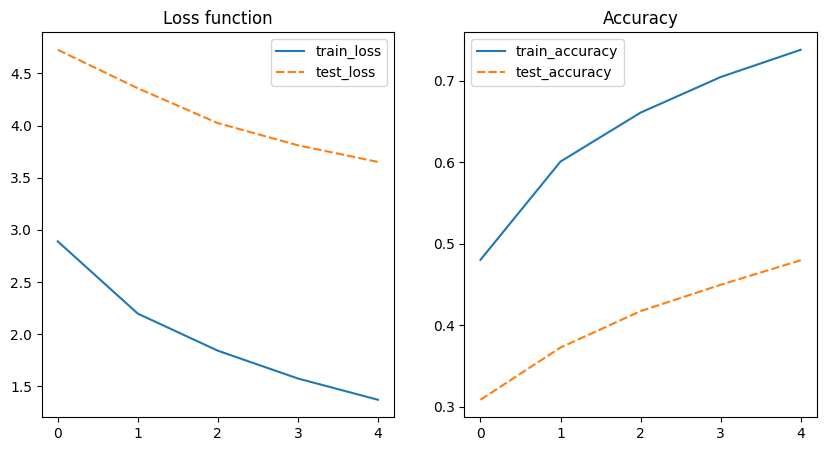

In [28]:
df = pd.DataFrame(data=history)
# Plot the learning curves (the loss function and the accuracy metric)
# which calculated on the training and test datasets
_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=df[['train_loss', 'test_loss']], ax=axs[0])
sns.lineplot(data=df[['train_accuracy', 'test_accuracy']], ax=axs[1])
axs[0].set_title('Loss function')
axs[1].set_title('Accuracy')
plt.show()

In [33]:
sentence = 'я иду в школу'
pred, att_weights = predict(sentence, 3)
print(pred)

i m in school


<Axes: >

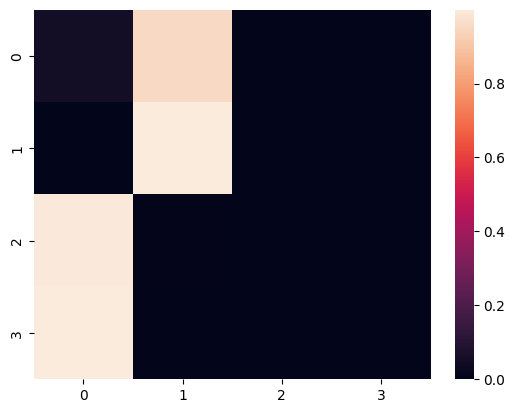

In [34]:
sns.heatmap(att_weights)

In [67]:
history = model.fit(X_encoder, X_decoder, Y_decoder, epoch=50, batch_size=32, train_size=0.8, learning_rate=0.001, is_verbose=True)

Train dataset: 248 batches, 7936 samples
Test dataset: 60 batches, 1920 samples
Epoch 1/50


Train dataset: 248it [03:50,  1.07it/s]


Loss on train: 3.9620 Accuracy on train: 0.2576


Test dataset: 60it [00:22,  2.61it/s]


Loss on test: 4.7500 Accuracy on test: 0.2038
Epoch 2/50


Train dataset: 248it [03:44,  1.11it/s]


Loss on train: 3.0957 Accuracy on train: 0.3806


Test dataset: 60it [00:23,  2.60it/s]


Loss on test: 4.4057 Accuracy on test: 0.2567
Epoch 3/50


Train dataset: 248it [03:43,  1.11it/s]


Loss on train: 2.7362 Accuracy on train: 0.4549


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 4.3079 Accuracy on test: 0.2903
Epoch 4/50


Train dataset: 248it [03:43,  1.11it/s]


Loss on train: 2.4399 Accuracy on train: 0.5081


Test dataset: 60it [00:22,  2.64it/s]


Loss on test: 4.2455 Accuracy on test: 0.3105
Epoch 5/50


Train dataset: 248it [03:45,  1.10it/s]


Loss on train: 2.1724 Accuracy on train: 0.5580


Test dataset: 60it [00:22,  2.72it/s]


Loss on test: 4.2171 Accuracy on test: 0.3240
Epoch 6/50


Train dataset: 248it [03:46,  1.09it/s]


Loss on train: 1.9318 Accuracy on train: 0.6040


Test dataset: 60it [00:24,  2.49it/s]


Loss on test: 4.2682 Accuracy on test: 0.3273
Epoch 7/50


Train dataset: 248it [03:45,  1.10it/s]


Loss on train: 1.7084 Accuracy on train: 0.6497


Test dataset: 60it [00:22,  2.68it/s]


Loss on test: 4.0630 Accuracy on test: 0.3534
Epoch 8/50


Train dataset: 248it [03:46,  1.09it/s]


Loss on train: 1.5040 Accuracy on train: 0.6909


Test dataset: 60it [00:22,  2.64it/s]


Loss on test: 4.1158 Accuracy on test: 0.3514
Epoch 9/50


Train dataset: 248it [03:50,  1.08it/s]


Loss on train: 1.3150 Accuracy on train: 0.7303


Test dataset: 60it [00:22,  2.62it/s]


Loss on test: 3.8705 Accuracy on test: 0.3853
Epoch 10/50


Train dataset: 248it [03:45,  1.10it/s]


Loss on train: 1.1473 Accuracy on train: 0.7655


Test dataset: 60it [00:22,  2.72it/s]


Loss on test: 3.7169 Accuracy on test: 0.4063
Epoch 11/50


Train dataset: 248it [03:46,  1.09it/s]


Loss on train: 0.9923 Accuracy on train: 0.7993


Test dataset: 60it [00:23,  2.53it/s]


Loss on test: 3.5924 Accuracy on test: 0.4372
Epoch 12/50


Train dataset: 248it [03:43,  1.11it/s]


Loss on train: 0.8583 Accuracy on train: 0.8278


Test dataset: 60it [00:22,  2.67it/s]


Loss on test: 3.4874 Accuracy on test: 0.4596
Epoch 13/50


Train dataset: 248it [03:41,  1.12it/s]


Loss on train: 0.7382 Accuracy on train: 0.8552


Test dataset: 60it [00:23,  2.57it/s]


Loss on test: 3.3551 Accuracy on test: 0.4899
Epoch 14/50


Train dataset: 248it [03:42,  1.12it/s]


Loss on train: 0.6319 Accuracy on train: 0.8787


Test dataset: 60it [00:22,  2.64it/s]


Loss on test: 3.3054 Accuracy on test: 0.5047
Epoch 15/50


Train dataset: 248it [03:55,  1.05it/s]


Loss on train: 0.5416 Accuracy on train: 0.8990


Test dataset: 60it [00:24,  2.46it/s]


Loss on test: 3.2390 Accuracy on test: 0.5263
Epoch 16/50


Train dataset: 248it [03:57,  1.04it/s]


Loss on train: 0.4610 Accuracy on train: 0.9159


Test dataset: 60it [00:24,  2.48it/s]


Loss on test: 3.1366 Accuracy on test: 0.5450
Epoch 17/50


Train dataset: 248it [03:55,  1.05it/s]


Loss on train: 0.3898 Accuracy on train: 0.9297


Test dataset: 60it [00:24,  2.43it/s]


Loss on test: 3.0954 Accuracy on test: 0.5604
Epoch 18/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.3270 Accuracy on train: 0.9433


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 3.0162 Accuracy on test: 0.5796
Epoch 19/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.2741 Accuracy on train: 0.9539


Test dataset: 60it [00:25,  2.39it/s]


Loss on test: 3.0600 Accuracy on test: 0.5823
Epoch 20/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.2261 Accuracy on train: 0.9628


Test dataset: 60it [00:24,  2.47it/s]


Loss on test: 3.0137 Accuracy on test: 0.5998
Epoch 21/50


Train dataset: 248it [03:59,  1.03it/s]


Loss on train: 0.1884 Accuracy on train: 0.9713


Test dataset: 60it [00:24,  2.42it/s]


Loss on test: 3.0403 Accuracy on test: 0.6021
Epoch 22/50


Train dataset: 248it [03:58,  1.04it/s]


Loss on train: 0.1526 Accuracy on train: 0.9793


Test dataset: 60it [00:24,  2.46it/s]


Loss on test: 2.9774 Accuracy on test: 0.6141
Epoch 23/50


Train dataset: 248it [03:58,  1.04it/s]


Loss on train: 0.1232 Accuracy on train: 0.9853


Test dataset: 60it [00:25,  2.40it/s]


Loss on test: 2.9754 Accuracy on test: 0.6215
Epoch 24/50


Train dataset: 248it [03:57,  1.05it/s]


Loss on train: 0.0980 Accuracy on train: 0.9892


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 2.9725 Accuracy on test: 0.6256
Epoch 25/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0783 Accuracy on train: 0.9911


Test dataset: 60it [00:24,  2.47it/s]


Loss on test: 3.0100 Accuracy on test: 0.6236
Epoch 26/50


Train dataset: 248it [03:58,  1.04it/s]


Loss on train: 0.0612 Accuracy on train: 0.9925


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 2.9799 Accuracy on test: 0.6303
Epoch 27/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0476 Accuracy on train: 0.9936


Test dataset: 60it [00:24,  2.44it/s]


Loss on test: 2.9477 Accuracy on test: 0.6405
Epoch 28/50


Train dataset: 248it [03:58,  1.04it/s]


Loss on train: 0.0371 Accuracy on train: 0.9944


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 2.9889 Accuracy on test: 0.6351
Epoch 29/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0289 Accuracy on train: 0.9947


Test dataset: 60it [00:24,  2.46it/s]


Loss on test: 2.9875 Accuracy on test: 0.6401
Epoch 30/50


Train dataset: 248it [03:58,  1.04it/s]


Loss on train: 0.0223 Accuracy on train: 0.9952


Test dataset: 60it [00:25,  2.37it/s]


Loss on test: 3.0212 Accuracy on test: 0.6403
Epoch 31/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0198 Accuracy on train: 0.9953


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 3.0122 Accuracy on test: 0.6452
Epoch 32/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0176 Accuracy on train: 0.9954


Test dataset: 60it [00:24,  2.46it/s]


Loss on test: 3.0305 Accuracy on test: 0.6409
Epoch 33/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0154 Accuracy on train: 0.9957


Test dataset: 60it [00:24,  2.47it/s]


Loss on test: 3.0404 Accuracy on test: 0.6432
Epoch 34/50


Train dataset: 248it [04:02,  1.02it/s]


Loss on train: 0.0139 Accuracy on train: 0.9957


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 3.0754 Accuracy on test: 0.6416
Epoch 35/50


Train dataset: 248it [04:02,  1.02it/s]


Loss on train: 0.0133 Accuracy on train: 0.9960


Test dataset: 60it [00:25,  2.39it/s]


Loss on test: 3.0793 Accuracy on test: 0.6437
Epoch 36/50


Train dataset: 248it [03:59,  1.03it/s]


Loss on train: 0.0129 Accuracy on train: 0.9960


Test dataset: 60it [00:24,  2.50it/s]


Loss on test: 3.0803 Accuracy on test: 0.6440
Epoch 37/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0123 Accuracy on train: 0.9960


Test dataset: 60it [00:24,  2.44it/s]


Loss on test: 3.1492 Accuracy on test: 0.6386
Epoch 38/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0119 Accuracy on train: 0.9960


Test dataset: 60it [00:24,  2.43it/s]


Loss on test: 3.1362 Accuracy on test: 0.6419
Epoch 39/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0114 Accuracy on train: 0.9963


Test dataset: 60it [00:24,  2.42it/s]


Loss on test: 3.1497 Accuracy on test: 0.6405
Epoch 40/50


Train dataset: 248it [04:02,  1.02it/s]


Loss on train: 0.0108 Accuracy on train: 0.9963


Test dataset: 60it [00:24,  2.49it/s]


Loss on test: 3.1363 Accuracy on test: 0.6436
Epoch 41/50


Train dataset: 248it [04:01,  1.03it/s]


Loss on train: 0.0109 Accuracy on train: 0.9963


Test dataset: 60it [00:24,  2.49it/s]


Loss on test: 3.1432 Accuracy on test: 0.6437
Epoch 42/50


Train dataset: 248it [04:02,  1.02it/s]


Loss on train: 0.0103 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 3.1992 Accuracy on test: 0.6385
Epoch 43/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0101 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.49it/s]


Loss on test: 3.1628 Accuracy on test: 0.6433
Epoch 44/50


Train dataset: 248it [04:00,  1.03it/s]


Loss on train: 0.0101 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.48it/s]


Loss on test: 3.1690 Accuracy on test: 0.6445
Epoch 45/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0102 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.46it/s]


Loss on test: 3.1779 Accuracy on test: 0.6451
Epoch 46/50


Train dataset: 248it [03:59,  1.03it/s]


Loss on train: 0.0100 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.49it/s]


Loss on test: 3.1853 Accuracy on test: 0.6443
Epoch 47/50


Train dataset: 248it [03:58,  1.04it/s]


Loss on train: 0.0106 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.46it/s]


Loss on test: 3.1871 Accuracy on test: 0.6429
Epoch 48/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0101 Accuracy on train: 0.9966


Test dataset: 60it [00:24,  2.45it/s]


Loss on test: 3.1910 Accuracy on test: 0.6434
Epoch 49/50


Train dataset: 248it [04:01,  1.03it/s]


Loss on train: 0.0101 Accuracy on train: 0.9965


Test dataset: 60it [00:24,  2.49it/s]


Loss on test: 3.1878 Accuracy on test: 0.6454
Epoch 50/50


Train dataset: 248it [03:59,  1.04it/s]


Loss on train: 0.0098 Accuracy on train: 0.9966


Test dataset: 60it [00:24,  2.45it/s]

Loss on test: 3.2137 Accuracy on test: 0.6421


In [ ]:
# with open(base_path + 'Data/machine_translation_bahdanau_attention_history.pickle', 'wb') as f:
#     pickle.dump(history, f)

In [ ]:
# with open(base_path + 'Data/machine_translation_bahdanau_attention_history.pickle', 'rb') as f:
#     history = pickle.load(f)

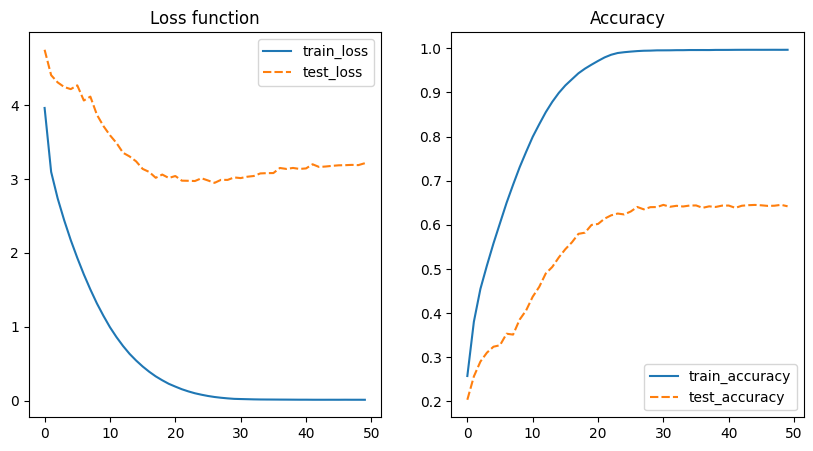

In [68]:
df = pd.DataFrame(data=history)
# Plot the learning curves (the loss function and the accuracy metric)
# which calculated on the training and test datasets
_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=df[['train_loss', 'test_loss']], ax=axs[0])
sns.lineplot(data=df[['train_accuracy', 'test_accuracy']], ax=axs[1])
axs[0].set_title('Loss function')
axs[1].set_title('Accuracy')
plt.show()

# 4. Inference

In [30]:
def predict(sentence: str, end_token_index: int) -> str:
  input = encoder_vec.predict([sentence])
  input = list(filter(lambda x: x!=0, input[0]))
  output, attention_weights = model.predict(np.array([input]))
  tokens, att_weights = [], []
  for idx, token in enumerate(output):
    if token == end_token_index:
      break
    tokens.append(token)
    att_weights.append(attention_weights[0][idx])
  return decoder_vec.token_to_text(tokens), att_weights

In [70]:
sentence = 'что это по твоему значит'
pred, att_weights = predict(sentence, 3)
print(pred)

what do you think that means


<Axes: >

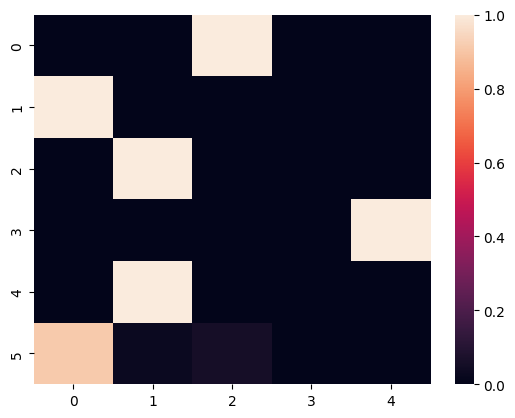

In [71]:
sns.heatmap(att_weights)

In [72]:
att_weights

[array([1.0240796e-03, 9.9490648e-24, 9.9897599e-01, 3.5698546e-20,
        2.0810479e-19], dtype=float32),
 array([1.0000000e+00, 3.7187452e-20, 3.1826011e-09, 1.7718335e-28,
        0.0000000e+00], dtype=float32),
 array([9.7538483e-27, 1.0000000e+00, 4.8048306e-23, 4.4961015e-10,
        2.8048440e-25], dtype=float32),
 array([2.5626730e-23, 2.5640923e-22, 1.1740332e-24, 4.1572061e-06,
        9.9999583e-01], dtype=float32),
 array([0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 4.8085954e-28,
        1.7993234e-21], dtype=float32),
 array([9.1208518e-01, 3.0186500e-02, 5.7715032e-02, 1.3125728e-05,
        8.1861167e-08], dtype=float32)]